In [22]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd

# Sampling
from pyDOE import lhs

import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf

from botorch.models.gp_regression import HeteroskedasticSingleTaskGP # This implements the variance of the y
from botorch.utils.transforms import normalize,unnormalize

# Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
from botorch.optim import optimize_acqf_mixed

# Device Set Up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


>## Functions

In [23]:
def gp_evaluate(gp, test_x):
    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                # ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=500, alpha=0.7,marker='.')
                # ax.set_xlabel(feature_names[j])
                # ax.set_ylabel(feature_names[i])
                # ax.set_box_aspect(1)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()


>## Import Data from Round 1 and 2

In [24]:
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# import data from csv
raw_data01 = pd.read_csv('/Users/ctuwsunlab/Documents/GitHub/PNNL-ML_for_Organic_Flow_Battery_Materials/Round1/extracted_data_round1.csv')
raw_data2B = pd.read_csv('/Users/ctuwsunlab/Documents/GitHub/PNNL-ML_for_Organic_Flow_Battery_Materials/Round2/ModelB/extracted_data_round2B.csv')
# average and standard deviation of the repeats
avg_data01 = raw_data01.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
std_data01 = raw_data01.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['01_yield product']].rename(columns = {'01_yield product':"var yield"})
data01 = pd.concat([avg_data01, std_data01], axis=1)

avg_data2B = raw_data2B.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['2B_time','2B_temp','2B_sulf','2B_anly','2B_yield product']].rename(columns = {'2B_time':"time",'2B_temp':"temp",'2B_sulf':"sulf",'2B_anly':"anly",'2B_yield product':"yield product"})
std_data2B = raw_data2B.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['2B_yield product']].rename(columns = {'2B_yield product':"var yield"})
data2B = pd.concat([avg_data2B, std_data2B], axis=1)

set_dataB = pd.concat([data01,data2B],axis=0,ignore_index=True)

>## Build Gaussian Process Regression

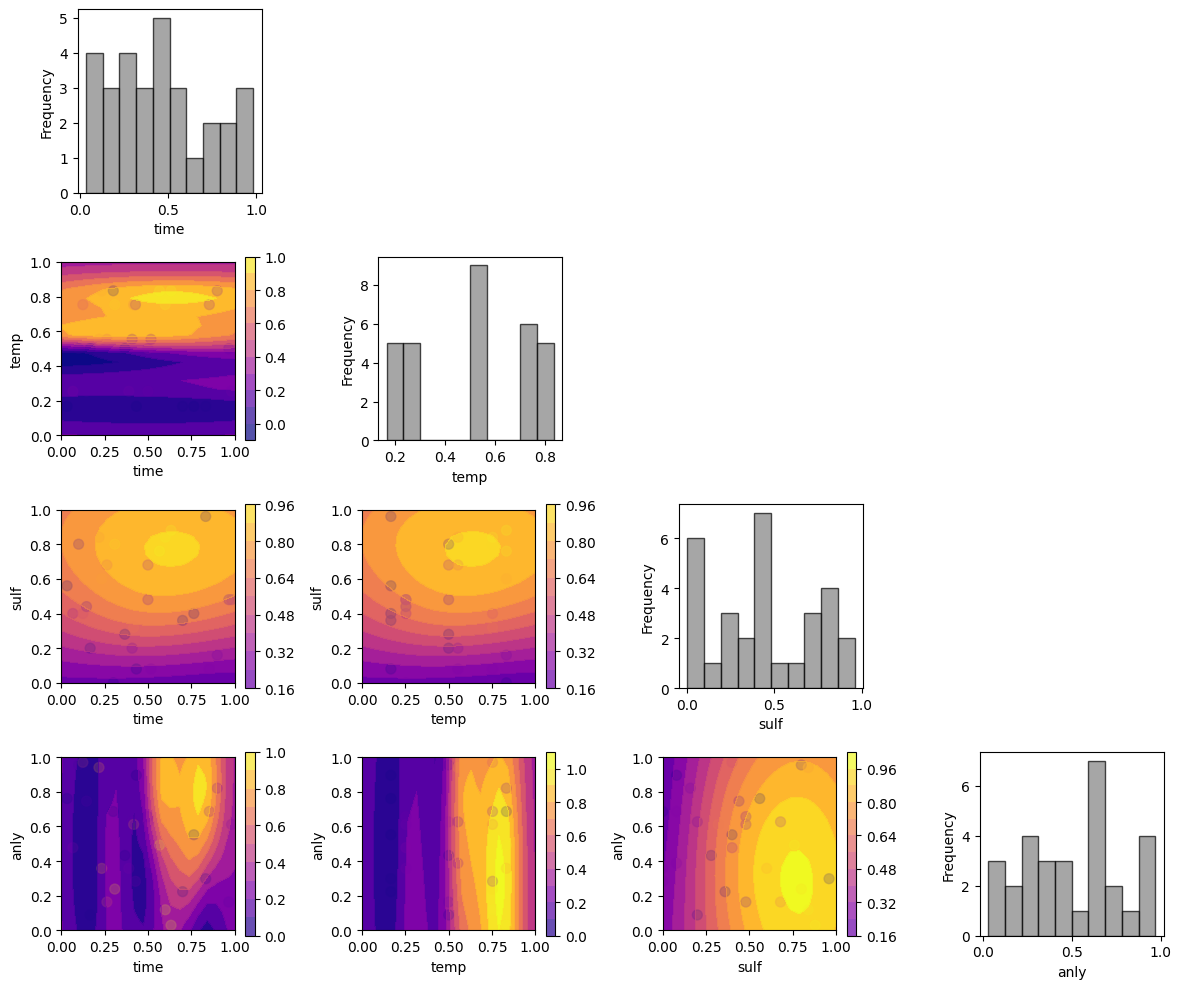

In [38]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x = torch.tensor([set_dataB['time'],set_dataB['temp'],set_dataB['sulf'],set_dataB['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(set_dataB['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(set_dataB['var yield'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)
## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(norm_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_fixed = 0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'plasma', f"Combination: {combination}")


>## 4D BO + Cluster (See Model A)

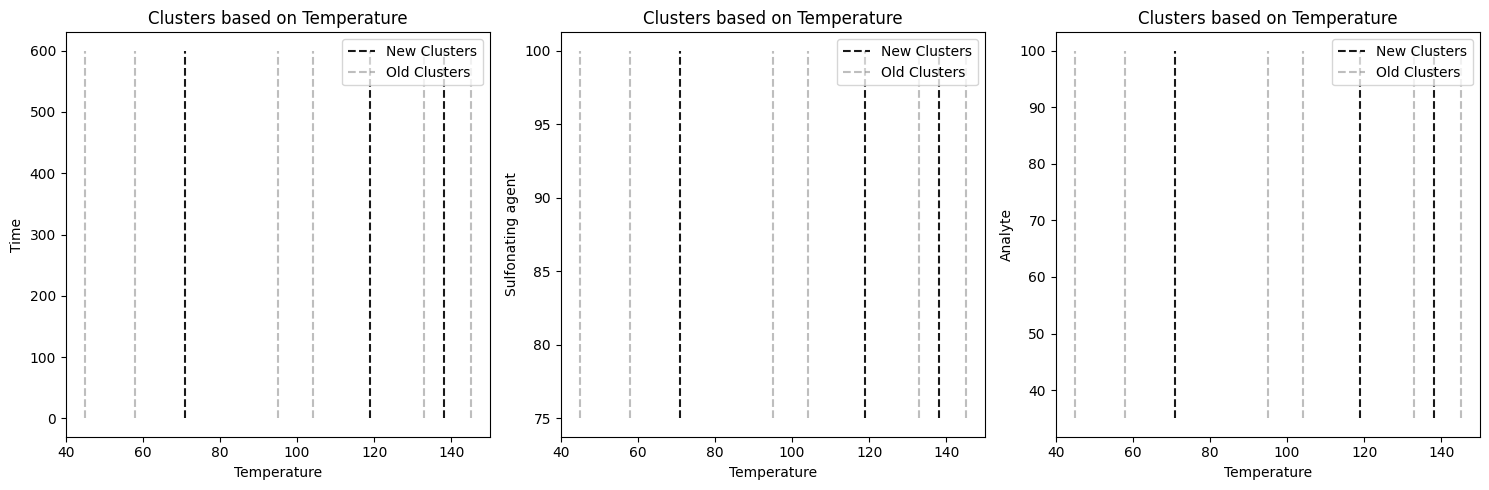

In [26]:
# USE SAME TEMPS FROM Model A
#Centroids of Temperature Clusters:
centroids = np.array([71.,  138., 119.])

old =  [45.,145.,95.,104.,58.,133.]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels = ['Time', 'Sulfonating agent', 'Analyte']
y_ranges = [(0, 600), (75, 100), (35, 100)]

for i, ax in enumerate(axes):
    ax.vlines(centroids, *y_ranges[i], color='k', linestyle='dashed', alpha=0.9, label='New Clusters')
    ax.vlines(old, *y_ranges[i], color='tab:grey', linestyle='dashed', alpha=0.5, label='Old Clusters')
    ax.set_xlabel('Temperature')
    ax.set_ylabel(labels[i])
    ax.set_title('Clusters based on Temperature')
    ax.legend()

plt.tight_layout()
plt.show()


>## BO Mixed variable

In [29]:
# BO parameters
batch_size = 15
# EI Set Up
best_f = torch.tensor(1, dtype=dtype)

# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
BO_bounds = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],  # Lower bounds for the 3 continuous variables
    [1.0, 1.0,1.0, 1.0]   # Upper bounds for the 3 continuous variables
])

# Discrete variable choices from 1D BO
discrete_choices = normalize(centroids,[20,170]).T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]



In [31]:
# Build a Mixed variable BO model
model = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=model, best_f=best_f)

# Re-run the BO for the mixed with constrained temps
candidates_mixed, _ = optimize_acqf_mixed(
    acq_function=qEI,
    bounds=BO_bounds,
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)

unnorm_candidates_mixed = unnormalize(candidates_mixed,bounds=bounds)


data = {
    'time': unnorm_candidates_mixed[:,0]//1,
    'temp': unnorm_candidates_mixed[:,1]//1,
    'sulf': unnorm_candidates_mixed[:,2]//1,
    'anly': unnorm_candidates_mixed[:,3]//1
}
data_df = pd.DataFrame(data)
data_df 

,time,temp,sulf,anly
0,498.0,71.0,98.0,48.0
1,433.0,119.0,98.0,93.0
2,499.0,138.0,98.0,98.0
3,449.0,119.0,91.0,40.0
4,431.0,71.0,93.0,47.0
5,400.0,138.0,91.0,49.0
6,237.0,138.0,100.0,79.0
7,145.0,119.0,100.0,71.0
8,175.0,119.0,77.0,50.0
9,499.0,71.0,87.0,54.0


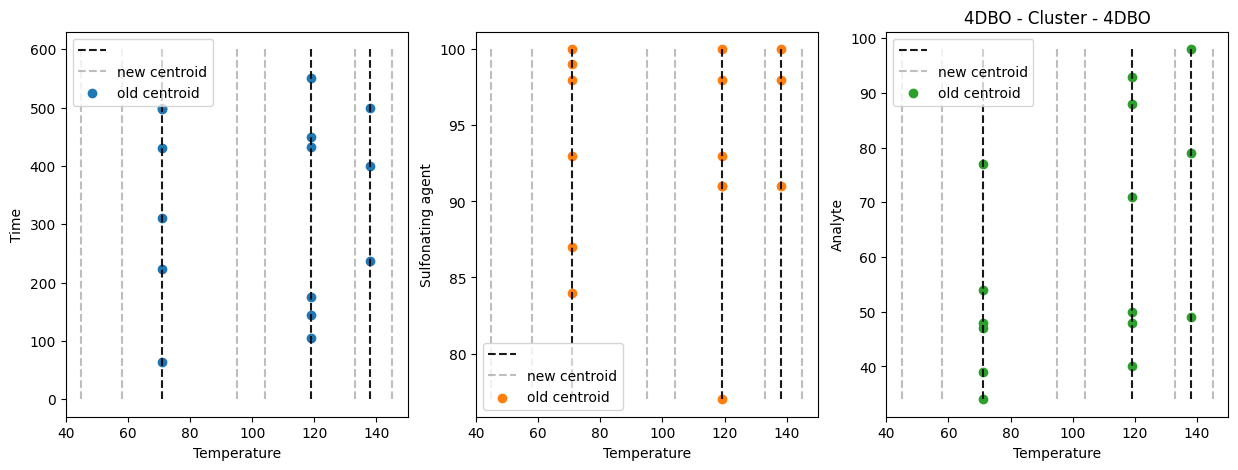

,time,temp,sulf,anly
0,498.0,71.0,98.0,48.0
1,433.0,119.0,98.0,93.0
2,499.0,138.0,98.0,98.0
3,449.0,119.0,91.0,40.0
4,431.0,71.0,93.0,47.0
5,400.0,138.0,91.0,49.0
6,237.0,138.0,100.0,79.0
7,145.0,119.0,100.0,71.0
8,175.0,119.0,77.0,50.0
9,499.0,71.0,87.0,54.0


In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])


plt.subplot(1,3,2)
plt.vlines(centroids,data_df['sulf'].min(),data_df['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,data_df['sulf'].min(),data_df['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(centroids,data_df['anly'].min(),data_df['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,data_df['anly'].min(),data_df['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])
plt.title('4DBO - Cluster - 4DBO')

plt.show()

data_df 


>## Send to data collection

In [ ]:
# # Build a Mixed variable BO model
# model = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
# mll = ExactMarginalLogLikelihood(model.likelihood, model)
# fit_gpytorch_model(mll)

# # Number of points per dimension
# num_points = 15

# # Define the ranges for each variable
# a_min, a_max = 30, 600 # 30 - 600
# b_min, b_max = 30, 150 #30 - 150
# c_min, c_max = 75, 100 # 75 - 100
# d_min, d_max = 33, 100 # 33- 100

# # Generate linspace for each variable
# a = torch.linspace(a_min, a_max, num_points)
# c = torch.linspace(c_min, c_max, num_points)
# d = torch.linspace(d_min, d_max, num_points)

# # Generate a list of three distinct values repeated to match 15 points
# b_values = torch.tensor([72., 119.,140.]) 
# b = b_values.repeat_interleave(num_points // len(b_values))
# # If num_points is not a multiple of len(d_values), you'll need to pad or trim
# b = torch.cat([b, b_values[:num_points % len(b_values)]]) if num_points % len(b_values) != 0 else b

# # Create the meshgrid
# A1, B2, C3, D4 = torch.meshgrid(a, b, c, d, indexing='ij')

# # Stack and reshape to the required grid shape
# grid_mix = torch.stack([A1.flatten(), B2.flatten(), C3.flatten(), D4.flatten()], dim=-1)
# grid_mix = normalize(grid_mix,bounds=bounds)

# # Evaluate the model on the grid
# mixed_mean, mixed_var = gp_evaluate(model, grid_mix)